# Select_Power

**Authors**: Joaquín Andrés Porras, Jesús del Hoyo

**Date**:   21/05/2024

**Motivation**: VDOEST project

**Objective**:

Seleccionar una potencia inicial. Para ello, usamos una lámina lambda/2 y un cubo polarizador. También usamos un medidor de potencia y los motores que giran la lámina lambda/2



## Carga de módulos necesarios


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime                                     # Datetime
import numpy as np                                  # Numpy
import py_lab.utils as utils                        # Utils py-lab
from scipy.optimize import least_squares            # Least squares
from py_lab.power_meter import Power_Meter           # Medidor de potencia
from py_lab.motor import Motor_Multiple             # Motores
from py_lab.config import degrees                   # Units

## Inicialización de los objetos

### Funciones previas

In [3]:
def model_cos2_2(par, angle):
    """Funcion cos**2 with parameters."""
    Imodel = par[0] + par[1] * np.cos(2*(angle - par[2]))**2
    return Imodel


def error_cos2_2(par, angle, Iexp):
    """Function that serves as optimization for cos**2."""
    Imodel = model_cos2_2(par, angle)
    dif = Iexp - Imodel
    return dif

### Medidor de potencia

In [4]:
# Inicio del medidor de potencia
pm = Power_Meter(name="Ophir")

('925808',)

----------Data for S/N 925808 ---------------


In [5]:
# Obtención de escala
pm.Print_Ranges()
range = pm.Get_Range(verbose=True)

Rango  0  =  AUTO
Rango  1  =  3.00W
Rango  2  =  300mW
Rango  3  =  30.0mW
Rango  4  =  3.00mW
Rango  5  =  300uW
Escala:  300mW


In [6]:
# Configuración de escala
pm.Set_Range(range=2, verbose=True);

Escala:  300mW
Background cleared!!!


### Motores

In [7]:
# Inicio de los motores
motor = Motor_Multiple(name="InteliDrives", N=3)
motor.Open(port='COM3', invert=False, axis=[0, 1, 2]) # Por defecto estos son los parámetros, pero podrían cambiarse

In [17]:
# Homing de los motores
pos = motor.Home(waiting='busy', verbose=True)

Current position is:
-  Motor 0: 90.036 deg.
-  Motor 1: 89.955 deg.
-  Motor 2: 90.045 deg.


In [9]:
# Comprobación de la posición inicial de los motores
pos = motor.Get_Position(units='deg', refered=True, verbose=True)

Current position is:
-  Motor 0: -0.009 deg.
-  Motor 1: -0.0 deg.
-  Motor 2: 0.018 deg.


In [20]:
# Comprobación del giro de los motores 90º
new_pos = motor.Move_Absolute(pos=[180, 180, 180], units='deg', refered=True, move_time=1, verbose=True, waiting='busy')

Current position is:
-  Motor 0: 180.009 deg.
-  Motor 1: 180.027 deg.
-  Motor 2: 180.018 deg.


## Toma de medidas


In [25]:
n_measures = 181


In [26]:
angles = np.linspace(0,180,n_measures)*degrees
Iexp = np.zeros(n_measures)

Primero tenemos que tomar la señal de referencia. Para ello, se enciende el láser, se deja un tiempo para que se estabilice la intensidad y se toma una señal directamente del láser

In [21]:
I_background = pm.Get_Power(Nmeasures=0, is_background=True, verbose=True)

Power:  -0.00020000000000000004
Time Stamp:  103498556.89438462
Status:  0.0


In [24]:
I_ref = pm.Get_Power(Nmeasures=0, use_background=True, verbose=True)

Power:  0.29218157894736835
Time Stamp:  103552842.58378948
Status:  0.0


Ahora, colocamos el cubo polarizador entre el láser y el medidor de potencia, y medimos la intensidad a la salida. Dividiendo entre el valor de I_ref, obtendremos lo que atenúa el cubo polarizador

In [ ]:
cube_attenuation = pm.Get_Power(Nmeasures=0, verbose=True)/I_ref


In [ ]:
print("El cubo polarizador atenúa un {:.2f}%.", cube_attenuation*100)

Ahora, colocamos la lámina lambda/2 entre el láser y el cubo polarizador. Medimos cada X grados y guardamos todos los valores

In [30]:
# Bucle de medidas
utils.percentage_complete()

for ind, angle in enumerate(angles): 
    motor.Move_Absolute(pos = [angle, angle, angle], units = 'rad')
    Iexp[ind] = pm.Get_Power(Nmeasures=0, verbose=False)
    utils.percentage_complete(ind, n_measures)


Completion:   0 %Power:  0.0478913043478261
Time Stamp:  103779082.94623673
Status:  0.0
  0 %Power:  0.04429444444444444
Time Stamp:  103786580.96994443
Status:  0.0
  1 %Power:  0.049561111111111104
Time Stamp:  103787780.65344445
Status:  0.0
  1 %Power:  0.05693333333333333
Time Stamp:  103788980.3371111
Status:  0.0
  2 %Power:  0.06468888888888889
Time Stamp:  103790180.02094445
Status:  0.0
  2 %Power:  0.07260555555555556
Time Stamp:  103791379.70472223
Status:  0.0
  3 %Power:  0.08083888888888889
Time Stamp:  103792579.38849999
Status:  0.0
  3 %Power:  0.08943888888888889
Time Stamp:  103793779.07216667
Status:  0.0
  4 %Power:  0.09818333333333334
Time Stamp:  103794978.75605555
Status:  0.0
  4 %Power:  0.10664117647058824
Time Stamp:  103796145.11558823
Status:  0.0
  5 %Power:  0.11546111111111111
Time Stamp:  103797311.47461112
Status:  0.0
  6 %Power:  0.12463333333333332
Time Stamp:  103798511.15744445
Status:  0.0
  6 %Power:  0.1334111111111111
Time Sta

## Análisis de medidas

Con estos valores, ajustamos a una función

 I = Imin + Imax * cos(2*(theta-theta_0))**2,
 
siendo theta el ángulo de giro de la lambda/2

In [31]:
# Obtención de parámetros de ajuste
(Imax, Imin) = (np.max(Iexp), np.min(Iexp))
bounds = ([0, 0, 0], [np.abs(Imin), Imax, 90 * degrees])
par0 = [np.max((0,Imin)), Imax - Imin, np.random.rand() * 90 * degrees]
result = least_squares(error_cos2_2, par0, args=(angles, Iexp), bounds=bounds)
par = result.x

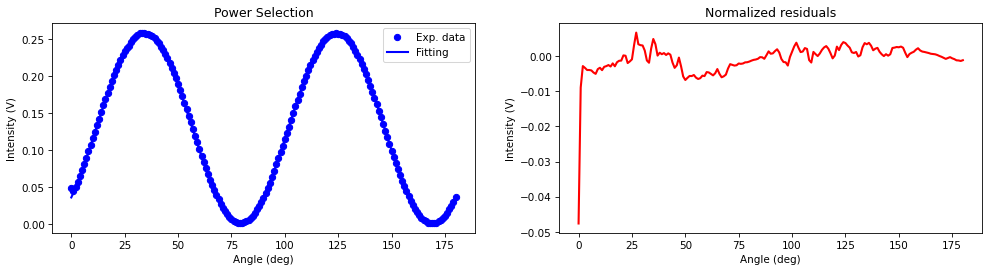

The normalized MSE is: 0.03 %.



In [32]:
# Representación de resultados experimentales con el ajuste realizado
Imodel = model_cos2_2(par, angles)
utils.plot_experiment_residuals_1D(angles, Iexp, Imodel, title='Power Selection')

## Guardado de los datos en un archivo

In [33]:
Power_Calibration = dict()

In [35]:
Power_Calibration['I_ref'] = I_ref
Power_Calibration['angles'] = angles
Power_Calibration['Iexp'] = Iexp
Power_Calibration['par'] = par
Power_Calibration['date_exp'] = datetime.date.today()
Power_Calibration['cube_attenuation'] = None
Power_Calibration['n_measures'] = n_measures
Power_Calibration['power_meter range'] = range

In [36]:
np.savez("Power_Calibration.npz", **Power_Calibration)

## Obtención de una potencia concreta

Ahora, creamos una función en la cual indicamos la potencia que necesitamos en el experimento, y la lambda/2 gira en la posición en la cual se obtiene esa potencia

In [37]:
def Get_Power(I, I0, cal_file, verbose = False): 
    
    """Obtienes la intensidad"""
    # Load calibration
    cal = np.load(cal_file) 
    
    # Intensity correction 
    I = I * cal["I_ref"] / I0
    
    # Load parameters    
    par = cal['par']
    
    # Power below lower limit
    if I < par[0]: 
        I = par[0]
        print("WARNING: I lower than limit: {:.2f}".format(par[0]*I0/I_ref))
        
    # Power over upper limit
    if I > par[0]+par[1]: 
        I = par[0]+par[1]
        print("WARNING: I upper than limit: {:.2f}".format((par[0]+par[1])*I0/I_ref))
    
    # Calculate angle
    angle = par[2] + .5 * np.arccos(np.sqrt((I - par[0]) / par[1]))
    
    # Move to position
    motor.Move_Absolute(pos = angle, axis= 2, units = 'rad')
    
    if verbose: 
        Iexp = pm.Get_Power(Nmeasures=0, verbose=True)[0]
        if np.abs(Iexp-I)/I <= 0.01: 
            print("Correcto")
        else: 
            print("Incorrecto")
    return 

In [38]:
filename = "Power_Calibration.npz"

In [39]:
Get_Power(0.1, 0.3, filename)

## Cierre de los objetos

### Medidor de potencia

In [ ]:
# Stop de toma de medidas
pm.Stop_Live()

In [40]:
# Cierre del medidor de potencia
pm.Close()

### Motores

In [41]:
# Cierre de los motores
motor.Close()